# Assignment 10 - UNet

In this assignement we are going to program our own UNet network (https://arxiv.org/pdf/1505.04597.pdf) which is a simple but powerful one. This network is made to produce a segmentation map. This segmentation map can be a little bit smaller than the true map but keep the same spatial structure. This map however is composed of several layers, one per class. The goal for the network is to activate pixel-wisely a layer if the pixel are representing the object of the layer.

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png", width=700)

The network look this way. The descending part is simply made out of convolution layer and pooling, easy peasy. This part of the network allow a move from the "Where?" information to the "What?" information. Then the informations are spatially dilated through a so called "transpose convolution" looking like a convoltuion mixed with an inverse pooling and then you convolute. as I sayed above, there is one layer of exit per class, don't trust the drawing, the initial version of this network was only design to say yes or not (That why there is two output layer)

In [5]:
Image(url= "https://miro.medium.com/max/3200/0*mk6U6zQDuoQLK7Ca", width=700)

After each big step of convolution, the informations are stacked to the last part of the network (grey arrow) reinjecting this way the "Where?" information.

# 10.1

Yo have to reproduce this network by yourself. The images takken for this work come from the PascalVOC database (http://host.robots.ox.ac.uk/pascal/VOC/). Here you inject RGB images into your network and out a "cube" of maps. The label of the data are on the shape of images with one channel, the background is represented by 0 and the differents class by a unique label (all the pixel filled out of ones are representing a plan typically.)

You have to use dtype=torch.float32 for the images and dtype=torch.long for the mask and every thing should run perfectly. Use also the criterion to use should be criterion = nn.CrossEntropyLoss() because he can understand the type of label injected (https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). 

Try to work on this early, the training can be slow (like 1h for 50 epoch ; batch : 100)

In [6]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Function
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
from PIL import Image
import time
import copy
import os

torch.__version__

'1.3.1'

In [0]:
class VOCSegLoader(torchvision.datasets.VOCSegmentation):
    def __init__(self, 
                 root, 
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 transforms=None):
        
        super(VOCSegLoader, self).__init__(root, year, image_set, download, transform, target_transform, transforms)


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        
        target = np.array(target)
        target[target == 255] = 0
        target = Image.fromarray(target)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        target = torch.as_tensor(np.asarray(target, dtype=np.uint8), dtype=torch.long)
        return img, target          

In [8]:
n_epochs = 3
batch_size = 4
#batch_size_train = 100
#batch_size_val = 100
learning_rate = 0.001
momentum = 0.9
log_interval = 10
image_size = (64, 85)


transform_data = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size), 
                                                 torchvision.transforms.ToTensor()])
transform_label = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size, interpolation=0)])



image_datasets = {x: VOCSegLoader('./data', year='2012', image_set=x, download=True,
                    transform=transform_data, target_transform=transform_label)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size)
              for x in ['train', 'val']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

0it [00:00, ?it/s]

1999642624it [03:00, 13193142.53it/s]                                

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


<class 'torch.Tensor'> torch.Size([3, 64, 85])
<class 'torch.Tensor'> torch.Size([64, 85])


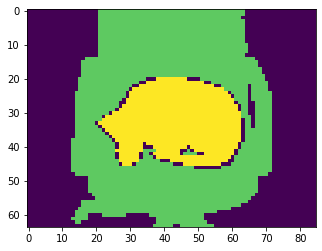

In [9]:
image, target = image_datasets['train'][2]
print(type(image), image.size())
print(type(target), target.size())

plt.figure()
plt.imshow(np.asarray(target))
plt.show()

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs):
    out = torchvision.utils.make_grid(inputs)
    #print(out.numpy())
    imshow(out)

In [0]:
# NETWORK
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)

        self.maxpool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024, 512, 3, stride=2)
        # cat
        self.conv11 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        # cat
        self.conv13 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv14 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, stride=2)
        # cat
        self.conv15 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv16 = nn.Conv2d(128, 128, 3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        # cat
        self.conv17 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv18 = nn.Conv2d(64, 64, 3, padding=1)

        self.upconvEXTRA = nn.ConvTranspose2d(64, 64, 3, stride=2)

        self.conv19 = nn.Conv2d(64, 21, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.up(*self.down(x))
    
    def down(self, x):
        a = F.relu(self.conv1(x))
        a = self.maxpool(F.relu(self.conv2(a)))

        b = F.relu(self.conv3(a))
        b = self.maxpool(F.relu(self.conv4(b)))

        c = F.relu(self.conv5(b))
        c = self.maxpool(F.relu(self.conv6(c)))
        
        d = F.relu(self.conv7(c))
        d = self.maxpool(F.relu(self.conv8(d)))

        e = F.relu(self.conv9(d))
        e = F.relu(self.conv10(e))

        return e, (a, b, c, d)
    
    def up(self, x, low_level_info):
        a, b, c, d = low_level_info

        f = self.upconv1(x)
        #print(d.shape,f.shape)  #torch.Size([100, 512, 3, 3])
        f = f[:,:,2:6,2:7]
        f = torch.cat((d,f),dim=1)
        f = F.relu(self.conv11(f))
        f = F.relu(self.conv12(f))

        g = self.upconv2(f)
        #print(c.shape,g.shape)
        g = g[:,:,1:,1:]
        g = torch.cat((c,g),dim=1)
        g = F.relu(self.conv13(g))
        g = F.relu(self.conv14(g))
        
        h = self.upconv3(g)
        #print(b.shape,h.shape)
        h = h[:,:,1:,:]
        h = torch.cat((b,h),dim=1)
        h = F.relu(self.conv15(h))
        h = F.relu(self.conv16(h))

        i = self.upconv4(h)
        # print(a.shape,i.shape)
        i = i[:,:,1:,1:]
        i = torch.cat((a,i),dim=1)
        # print(i.shape)
        i = F.relu(self.conv17(i))
        i = F.relu(self.conv18(i))

        j = self.upconvEXTRA(i)
        #print(j.shape)
        j = j[:,:,1:,:]

        k = self.conv19(j)
        k = self.softmax(k)

        #print(k)
        #print(k.shape)
        return k


model = Net()

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        for i, data in enumerate(dataloaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 150 == 149:    # print every 150 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 150))
                running_loss = 0.0

    print('Finished Training')
    return model

In [12]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 1/10
----------
[1,   150] loss: 3.044
[1,   300] loss: 3.041
Epoch 2/10
----------
[2,   150] loss: 3.036
[2,   300] loss: 3.032
Epoch 3/10
----------
[3,   150] loss: 3.024
[3,   300] loss: 3.017
Epoch 4/10
----------
[4,   150] loss: 3.003
[4,   300] loss: 2.988
Epoch 5/10
----------
[5,   150] loss: 2.949
[5,   300] loss: 2.889
Epoch 6/10
----------
[6,   150] loss: 2.505
[6,   300] loss: 2.380
Epoch 7/10
----------
[7,   150] loss: 2.368
[7,   300] loss: 2.374
Epoch 8/10
----------
[8,   150] loss: 2.367
[8,   300] loss: 2.373
Epoch 9/10
----------
[9,   150] loss: 2.366
[9,   300] loss: 2.372
Epoch 10/10
----------
[10,   150] loss: 2.366
[10,   300] loss: 2.372
Finished Training


torch.Size([4, 64, 85])
torch.Size([4, 21, 64, 85])
torch.Size([4, 64, 85])
tensor([[[0.9918, 0.9987, 1.0000,  ..., 1.0000, 0.9994, 0.9952],
         [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9994, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9997],
         ...,
         [0.9893, 0.9977, 1.0000,  ..., 1.0000, 1.0000, 0.9997],
         [0.9474, 0.9819, 0.9988,  ..., 1.0000, 0.9991, 0.9931],
         [0.8934, 0.9533, 0.9917,  ..., 0.9998, 0.9955, 0.9711]],

        [[0.9880, 0.9976, 1.0000,  ..., 0.9997, 0.9919, 0.9720],
         [0.9993, 0.9999, 1.0000,  ..., 1.0000, 0.9995, 0.9979],
         [0.9989, 0.9999, 1.0000,  ..., 1.0000, 0.9997, 0.9966],
         ...,
         [0.9531, 0.9814, 0.9991,  ..., 0.9988, 0.9801, 0.9507],
         [0.8828, 0.9375, 0.9876,  ..., 0.9829, 0.9280, 0.8746],
         [0.8236, 0.8906, 0.9598,  ..., 0.9531, 0.8873, 0.8136]],

        [[0.9943, 0.9992, 1.0000,  ..., 1.0000, 0.9995, 0.9961],
         [0.9998, 1.0000, 1.0000,  ..., 1.0000,

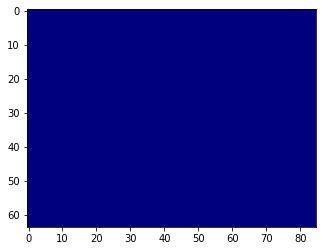

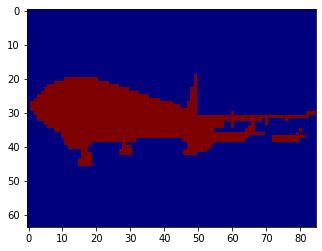

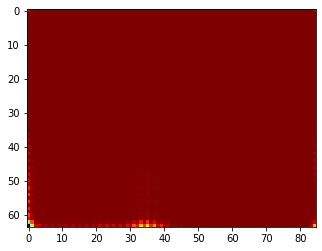

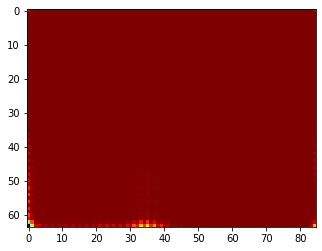

In [13]:
# VISUALIZE PREDICTION
def visualize(model):
    with torch.no_grad():
        for data in dataloaders['val']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(labels.shape)
            outputs = model(inputs)
            print(outputs.shape)
            #print(outputs[0,:,0,0])
            value, position = torch.max(outputs, dim=1)
            print(value.shape)
            #print(position.shape)
            #print(torch.max(position[3,:,:]))
            
            print(value)

            pred_plot1 = position[0,:,:].cpu().numpy()
            pred_plot2 = labels[0,:,:].cpu().numpy()
            pred_plot3 = value[0,:,:].cpu().numpy()
            pred_plot4 = outputs[0,0,:,:].cpu().numpy()
            

            fig, ax = plt.subplots()
            ax.imshow(pred_plot1, cmap='jet')
            fig, ax = plt.subplots()
            ax.imshow(pred_plot2, cmap='jet')
            fig, ax = plt.subplots()
            ax.imshow(pred_plot3, cmap='jet')
            fig, ax = plt.subplots()
            ax.imshow(pred_plot4, cmap='jet')
            plt.show()

            break
    
visualize(model.to(device))

In [14]:
print(device)

cuda:0


For double checking we used https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets/blob/master/Models.py
The syntax nicer and more compact of course but we can't find any significant (semantic/theoretic) differences.
Thus, we don't really know why our output isn't being visualized correctly. :(

## 10.2
Once you have done that, we want you to redesign a network where you remove to reinjection link (grey arrow on the drawing). You can remove the both from your choice just try and tell us if it's still working and why.

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class NoReinjectionUNet(Net):
    def __init__(self, remove_reinjections=(0, 1, 2, 3)):
        """
        remove_reinjections: For what (vertical) depths of the UNet 
            to remove the reinjections.
        """
        super().__init__()
        self.remove_reinjections = remove_reinjections

        if 0 in remove_reinjections:
            self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        if 1 in remove_reinjections:
            self.conv13 = nn.Conv2d(256, 256, 3, padding=1)
        if 2 in remove_reinjections:
            self.conv15 = nn.Conv2d(128, 128, 3, padding=1)
        if 3 in remove_reinjections:
            self.conv17 = nn.Conv2d(128, 64, 3, padding=1)

    def up(self, x, low_level_info):
        a, b, c, d = low_level_info

        f = self.upconv1(x)
        #print(d.shape,f.shape)  #torch.Size([100, 512, 3, 3])
        if 3 not in self.remove_reinjections:
            f = f[:,:,2:6,2:7]
            f = torch.cat((d,f),dim=1)
        f = F.relu(self.conv11(f))
        f = F.relu(self.conv12(f))

        g = self.upconv2(f)
        #print(c.shape,g.shape)
        if 2 not in self.remove_reinjections:
            g = g[:,:,1:,1:]
            g = torch.cat((c,g),dim=1)
        g = F.relu(self.conv13(g))
        g = F.relu(self.conv14(g))
        
        h = self.upconv3(g)
        #print(b.shape,h.shape)
        if 1 not in self.remove_reinjections:
            h = h[:,:,1:,:]
            h = torch.cat((b,h),dim=1)
        h = F.relu(self.conv15(h))
        h = F.relu(self.conv16(h))

        i = self.upconv4(b)
        #print(a.shape,i.shape)
        if 0 not in self.remove_reinjections:
            i = i[:,:,1:,1:]
            i = torch.cat((a,i),dim=1)
        i = F.relu(self.conv17(i))
        i = F.relu(self.conv18(i))

        j = self.upconvEXTRA(i)
        #print(j.shape)
        j = j[:,:,1:,:]

        k = self.conv19(j)
        k = self.softmax(k)

        #print(k)
        #print(k.shape)
        return k

model = NoReinjectionUNet()

> tell us if it's still working and why

The network should still "work".
By that we mean that the inputs still produce valid outputs.

BUT: The accuracy will be worse than for the actual `UNet` because the low-level information about pixel positions is missing.


## 10.3 BONUSTOCOME

...patiently waiting ;)